Apply basic GAN for MNIST data

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Sequential
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
#Defining the key parameter
#About mnist
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

#The size of the noise vector used for the generator input
z_dim = 100

In [3]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256*7*7, input_dim=z_dim))
    model.add(Reshape((7,7,256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
    return model

In [4]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=img_shape, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [5]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [6]:
#Building and compiling a discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

#Building and compiling a gan
generator = build_generator(z_dim)
#Fixed discriminator parameters during generator construction
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iteration, batch_size, sample_interval):
    
    #Load mnist dataset
    (x_train, _), (_, _) = mnist.load_data()
    #Scaling to [-1, 1]
    x_train = x_train / 127.5 -1.0
    x_train = np.expand_dims(x_train, axis=3)
    
    #Labeling
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)
        
        if(iteration + 1) % sample_interval == 0:
            
            losses.append((d_loss, g_loss))
            accuracies.append(100.0*accuracy)
            iteration_checkpoints.append(iteration+1)
            
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(iteration+1, d_loss, 100*accuracy, d_loss))
            
            sample_images(generator)

In [8]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):
    
    z = np.random.normal(0, 1, (image_grid_rows*image_grid_columns, z_dim))
    
    gen_imgs = generator.predict(z)
    
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows, image_grid_columns, figsize=(4,4), sharey=True, sharex=True)
    
    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1000 [D loss: 0.035202, acc.: 99.22%] [G loss: 0.035202]
2000 [D loss: 0.053786, acc.: 99.22%] [G loss: 0.053786]
3000 [D loss: 0.028439, acc.: 100.00%] [G loss: 0.028439]
4000 [D loss: 0.131126, acc.: 97.66%] [G loss: 0.131126]
5000 [D loss: 0.047317, acc.: 100.00%] [G loss: 0.047317]
6000 [D loss: 0.099806, acc.: 97.27%] [G loss: 0.099806]
7000 [D loss: 0.044234, acc.: 99.61%] [G loss: 0.044234]
8000 [D loss: 0.025710, acc.: 100.00%] [G loss: 0.025710]
9000 [D loss: 0.083810, acc.: 98.05%] [G loss: 0.083810]
10000 [D loss: 0.110903, acc.: 97.27%] [G loss: 0.110903]
11000 [D loss: 0.075561, acc.: 99.22%] [G loss: 0.075561]
12000 [D loss: 0.041881, acc.: 99.22%] [G loss: 0.041881]
13000 [D loss: 0.072618, acc.: 98.83%] [G loss: 0.072618]
14000 [D loss: 0.045707, acc.: 100.00%] [G loss: 0.045707]
15000 [D loss: 1.325301, acc.: 58.98%] [G loss: 1.325301]
16000 [D loss: 0.027379, acc.: 100.00%] [G loss: 0.027379]
17000 [D loss: 0.043798, acc.: 100.00%] [G loss: 0.043798]
18000 [D loss: 0.

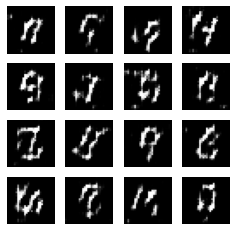

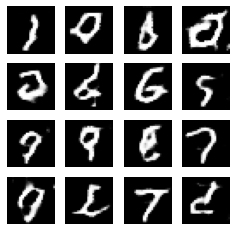

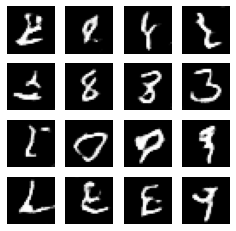

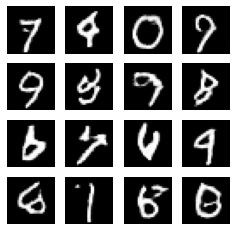

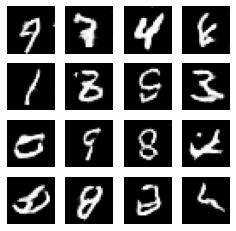

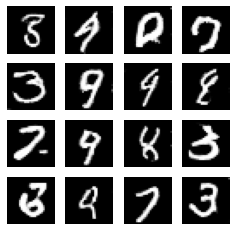

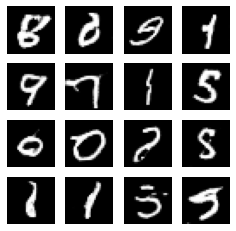

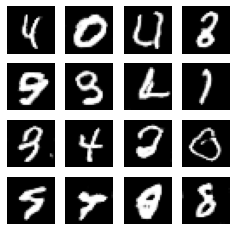

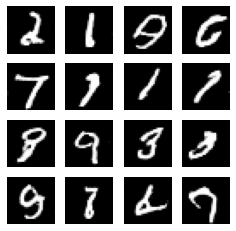

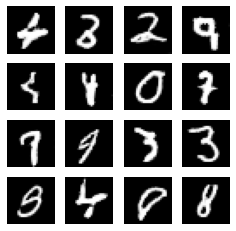

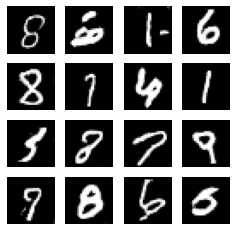

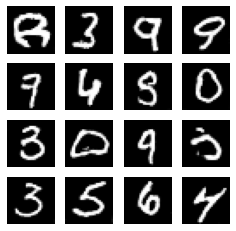

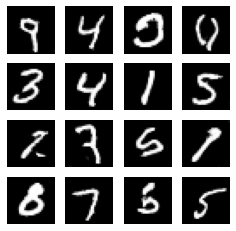

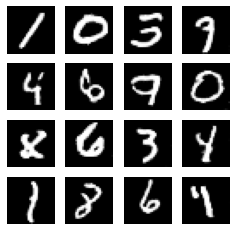

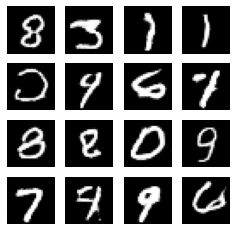

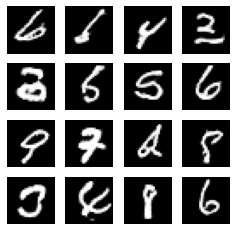

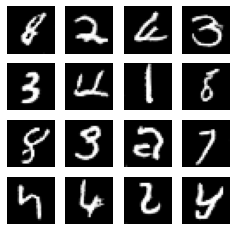

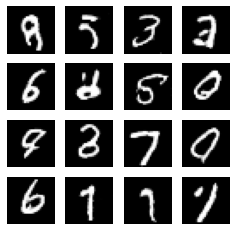

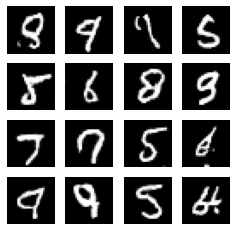

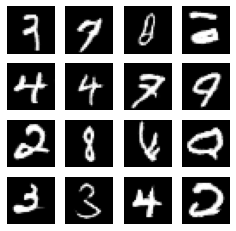

In [9]:
iterations = 20000
batch_size = 128
sample_interval = 1000

train(iterations, batch_size, sample_interval)